# Spiking Phasor VSA: Stochastic Functions

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm
from phasorutils import *
from brian2 import *
from numpy import *
from matplotlib.pyplot import *
from spikingVSA import *
from copy import deepcopy

In [2]:
# Define a few functions for convenience
def gaussian(x, mu, sig):
    return 1./(sqrt(2.*pi)*sig)*exp(-power((x - mu)/sig, 2.)/2)

def func(xx, c):
    x = xx
    y = 0.
    for cc in c:
        y += gaussian(x, cc, 0.5) * 0.5
    #y = 0.5 * gaussian(x, -3.3, 0.4) + 0.5 * gaussian(x, 0.6, 0.5) # + gaussian(x, 0, 0.75)
    return y

def gensignal(t, c, pause):
    L = 7.
    v = zeros_like(t)
    mask = t>=pause
    v = c[0]*sin((t-pause)*2*pi/L) * mask
    for k,cc in enumerate(c[1:]):
        v += cc*sin(2*k*(t-pause)*2*pi/L) * mask
    return array(v)

def rot(d):
    theta = d/180*pi
    return array([[cos(theta), -sin(theta)],
                  [sin(theta), cos(theta)]])

def sample(x):
    return random.normal(mu(x), sig(x))

# Create a function to encode

In [3]:
m = 5  # function defined in domain (-m, m)

cmu = random.normal(size=(3,))/2.   # parameters for function mean
mu = lambda x: gensignal(x,cmu,-100)  # mean of the function

csig = random.uniform(low=-m+1, high=m-1, size=2)  # params for std dev
# Function for std dev
#sig = lambda x: zeros_like(x)    # Use this for no variance
sig = lambda x: func(x, csig)/3.  # Use this for Gaussian process

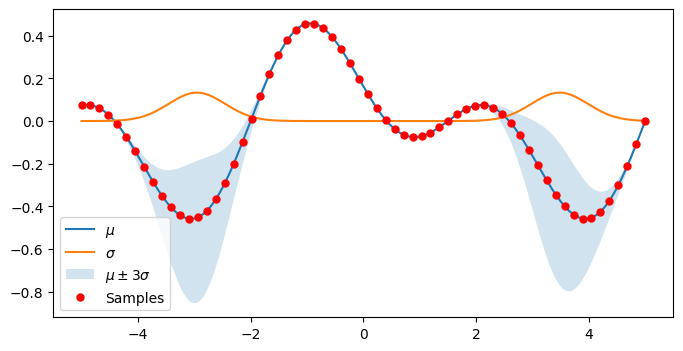

In [4]:
figure(figsize=(8,4))
xvals = linspace(-m, m, 201)
plot(xvals, mu(xvals), alpha=1);
plot(xvals, sig(xvals), alpha=1);
fill_between(xvals, mu(xvals)-3*sig(xvals), mu(xvals)+2*sig(xvals), alpha=0.2)
x_samples = linspace(-m, m, 64)
plot(x_samples, mu(x_samples), 'ro', ms=5);
legend([r'$\mu$', r'$\sigma$', r'$\mu\pm 3\sigma$', 'Samples']);

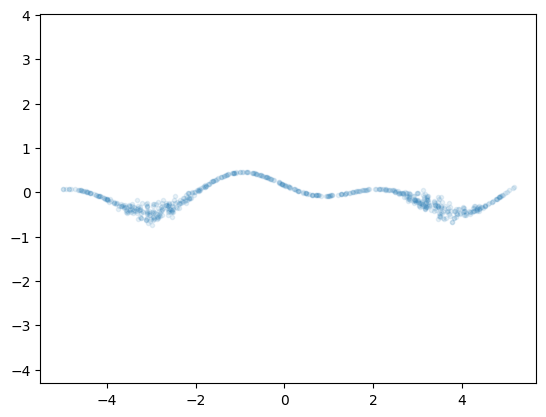

In [5]:
# Create samples from the Gaussian process
delta_s = 1.*m/64
delx = 0.01
xsamps = [-m]   # to store the x-values
xx = xsamps[0]
fsamps = [mu(xx)]  # to store the corresponding f-values

# This distributes the samples the function uniformly across
# the curve's arclength.
while xx<=m:
    dy = mu(xx+delx) - fsamps[-1]
    s = sqrt(delx**2 + dy**2)
    dx = delta_s * delx / (s)
    xx += dx
    n_samples = 2 #int(1. + 10*sig(xx))
    for k in range(n_samples):
        xn = xx + (1.+2.*random.normal())*dx
        f = sample(xn)
        xsamps.append(xn)
        fsamps.append(f)

xsamps = array(xsamps)
fsamps = array(fsamps)

plot(xsamps, fsamps, '.', alpha=0.1);
axis('equal');

# Create a bundle from samples

In [6]:
freq = 10.

ds = HexSSP(dtheta=5, nscales=120)

xaxis = ds.S[0]
faxis = ds.S[1]

N = len(ds.S[0])
print(f'Hypervector dimension: {N}')

Number of phasors: 2
Hypervector dimension: 8640


-5 0.2


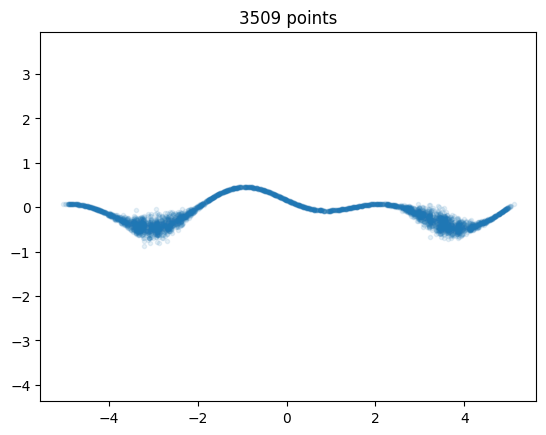

In [7]:
ds = m/200
delx = 0.01
xsamps = [-m]
xx = xsamps[0]
fsamps = [mu(xx)]

# Choose scale parameters for encoding x and f
fscale = 0.2
xscale = 0.2

# Start the bundle with the first sample
x = xaxis**(xx/xscale)  # 
print(xx, xscale)
f = faxis**(mu(xx)/fscale)
fbundle = x*f

while xx<=m:
    dy = mu(xx+delx) - fsamps[-1]
    s = sqrt(delx**2 + dy**2)
    dx = ds * delx / (s)
    xx += dx
    n_samples = 4 #int(2. + 10*sig(xx))
    for k in range(n_samples):
        xn = xx + (1.+2.*random.normal())*dx
        f = sample(xn)
        xsamps.append(xn)
        fsamps.append(f)

        x = xaxis**(xn/xscale)
        f = faxis**(f/fscale)
        fbundle += x*f

mask = abs(fbundle)>0.5
fbundle[mask] /= abs(fbundle[mask])   # make it unitary
xsamps = array(xsamps)
fsamps = array(fsamps)

plot(xsamps, fsamps, '.', alpha=0.1);
title(f'{len(xsamps)} points'); axis('equal');
savefig('Gaussian_process.pdf')

# Create the network

In [8]:
net = SpikingPhasorNet()

# Spiking phasor (SP) population to output the bundle
F = GenerateSP(N=N, C=fbundle, freq=freq); net.add_pop(F)

# SP pop to output a location
xx = 0.4
X = GenerateSP(N=N, C=xaxis**(xx/xscale), freq=freq); net.add_pop(X)

# Phase difference (unbinding)
z = PhaseDiffPop(N=N, freq=freq); net.add_pop(z)
net.deconvolve(F, X, z)

net.br.store()

In [9]:
net.total_neurons()

25920

In [10]:
# Run the network for a bunch of different x-values

n_samples = 101
xrange = [-m,m]
frange = [-2, 2]
xvals = linspace(xrange[0], xrange[1], n_samples)
fvals = linspace(frange[0], frange[1], 401)/fscale
fx = []
allfx = []
for xx in tqdm(xvals):
    net.br.restore()
    x = xaxis**(xx/xscale)
    X.set_spikes(C=x)
    net.run(0.2*second)
    max_i, sims = spatial_similarity(z, faxis, fvals, start_time=0.1)
    fx.append(fscale*fvals[max_i])
    allfx.append(sims)
allfx = array(allfx)

100%|███████████████████████████████████████████████████████████████████████████████████| 101/101 [01:33<00:00,  1.09it/s]


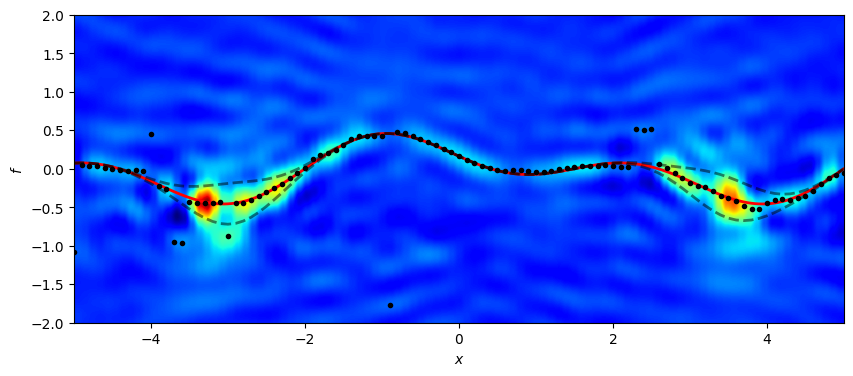

In [11]:
# Plot the similarity over the (x,f) plane,
# along with the Gaussian process.
figure(figsize=(xrange[1]-xrange[0],frange[1]-frange[0]))
imshow(allfx.T, extent=(xrange[0],xrange[1],frange[0],frange[1]), origin='lower', cmap='jet')
xxvals = linspace(-m, m, 401)
plot(xxvals, mu(xxvals), 'r', lw=2);
plot(xvals, fx, 'k.', mew=2, ms=4);
plot(xvals, mu(xvals)-2*sig(xvals), 'k--', alpha=0.5, lw=2);
plot(xvals, mu(xvals)+2*sig(xvals), 'k--', alpha=0.5, lw=2);
xlabel(r'$x$'); ylabel(r'$f$');
savefig('function_bundle.pdf');